# Introduction to Machine Learning

In this lab, we will introduce the fundamentals of machine learning.

## Supervised Machine Learning

Let's begin by introducing the concept of supervised learning. We're going to work with [Census Income dataset](https://archive.ics.uci.edu/ml/datasets/Census+Income) on the UCI Machine Learning Repository. In supervised machine learning, we start with a structured dataset where each observation is a row and each variable is a column. The goal is to use a number of features (previously you might have called these "covariates," "independent variables," or "regressors") to train a model that predicts a target (previously you might have called these "outcome variable" or "dependent variable"). In this case, we will use information like age, education, and marital status to predict each person's income-bracket.

First let's load the data. The data is stored in a ".data" format so we'll use the pandas "read_table" method.

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelBinarizer 
from sklearn.metrics import roc_curve, roc_auc_score

%matplotlib inline
sns.set_style("darkgrid")

In [2]:
# Create a list of column names, found in "adult.names"
col_names = ['age', 'workclass', 'fnlwgt',
            'education', 'education-num',
            'marital-status', 'occupation', 
             'relationship', 'race', 
             'sex', 'capital-gain',
            'capital-loss', 'hours-per-week',
            'native-country', 'income-bracket']

# Read table from the data folder
census = pd.read_table(os.getcwd()+"/data/adult.data", sep = ',', names = col_names)

In [3]:
# Look at the first 5 rows
census.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Data Preprocessing

Before we predict income-bracket, we need to think about a few questions.

1. What features should we include?
2. What is the best model?
3. How do we evaluate the model?

First let's think about the features. Check the different data types in our dataset. What do you notice?

In [4]:
census.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income-bracket    object
dtype: object

**Answer**: Some of our features are numeric (`int64`), but others just say `object`. The latter are strings here, which cannot be passed directly to a machine learning model. In other datasets, also be careful of numbers that are read as numeric but actually are categories such as zip codes!

Before we pass these features into a model, we need to convert the categorical features to numerical information. Our target is also categorical, so we will need to transform that column as well. Starting with the outcome, income-bracket, use sklearn's [LabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) to convert the **income-bracket** column to a binary outcome (0 for "<=50k" and 1 for ">50k"). 

In [5]:
lb = LabelBinarizer()
census['income-bracket-binary'] = lb.fit_transform(census["income-bracket"])
census.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-bracket,income-bracket-binary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,0
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K,0
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K,1
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K,1
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K,1


Now let's look at the features we will use for prediction. There are a couple of different ways we could convert our categorical features to numerical ones. One simple way to do this is to convert them into dummy variables. Use the pandas [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) method to convert the categorical variables into dummy variables. Be sure to drop the target variable (and the one we created) as well.

In [6]:
X = pd.get_dummies(data=census, columns=["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"])
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income-bracket,income-bracket-binary,workclass_ ?,workclass_ Federal-gov,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,<=50K,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,<=50K,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Notice that all of our categorical variables have been converted. Instead of strings, we now either have a 0 or a 1 in their place, and new columns representing each category. Take a look at the shape and structure of this new dataframe compared to the original. What can you say about these two dataframes? Is there new information, or is it presented differently? 

In [7]:
print("Dimensions of Dummy Dataframe are", X.shape)
print("Dimensions of the Original Dataframe are", census.shape)

Dimensions of Dummy Dataframe are (32561, 110)
Dimensions of the Original Dataframe are (32561, 16)


**Your Answer**: There are many more columns in the new dataframe - nearly 100 more! But the information presented isn't "new" - it's just spread across many columns.

### Curse of Dimensionality and Sparsity

This data preprocessing reveals two important concepts in machine learning. Namely, [**the curse of dimensionality** and **sparsity**](https://www.kaggle.com/residentmario/curse-of-dimensionality). A sparse matrix is one filled mainly with 0s, as we see above. In geometric terms, this property means that most combinations of features are totally empty. The curse of dimensionality refers to the idea that as the number of features grow, the number of observations needed to properly model predictions grows as well. The problem is that that number of observations required grows much faster than the number of features. Trading off between increasing features to improve model performance, but reducing the number of features to avoid the instability and overfitting that occurs with too few observations, is at the heart of supervised machine learning. 

## Data Splitting

Another key aspect of machine learning is splitting our data. In your previous statistics classes, you likely fit regression models on an entire dataset. The problem with fitting a model this way is that models will tend to perform better on the data that they are trained on, but then perform less well on out of sample data. The error in a machine learning model comes from two sources:

**Bias**: Error arising from the difference between the predicted output and the actual output. High bias models tend to be too simple and **underfit** the dataset.

**Variance**: Error arising from modeling the noise in the output. High variance models tend to be too complex and **overfit** the dataset.

The [**bias-variance tradeoff**](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) is a fundamental concept in machine learning. The less bias in a model, the higher the variance and vice versa. [Underfitting or overfitting](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html) a model makes generalizing to new data difficult. Trading off between these two sources of error is an essential part of machine learning. Over the next few weeks, we will explore how to deal with bias-variance tradeoff in the modeling process. Today, we'll look at how our choices in the data splitting step affect bias-variance tradeoff as well.

## Cross-Validation

As you can see, choosing the optimal train/validation/test split can be difficult. It is also prone to high variance problems as the machine learning algorithm's performance will be very dependent on the composition of the randomly sampled test split. This problem is exacerbated in small datasets especially. One way to address this problem is with [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#:~:text=Cross%2Dvalidation%2C%20sometimes%20called%20rotation,to%20an%20independent%20data%20set).

The general procedure is:

1. Randomly split the data into k-folds
2. Build the model on k-1 folds, then test on the last fold
3. Record prediction error
4. Cycle until each fold has served as the test set
5. The average of the errors is the cv-error

Cross-validation has the advantage of allowing every data point to be in the test set once. By averaging the errors, the model is less sensitive to variation in the random samples, and is less prone to overfitting. Let's try with our logistic regression again, using the [cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) method.

In [8]:
X = census.drop(['income-bracket', 'income-bracket-binary'], axis = 1)
X = pd.get_dummies(X)

y = census['income-bracket-binary']

log_pred = ...

cf_matrix = confusion_matrix(y, log_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
              range(2))

df_cm = df_cm.rename(index=str, columns={0: "<=50k", 1: ">50k"})
df_cm.index = ["<=50k", ">50k"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

TypeError: Expected sequence or array-like, got <class 'ellipsis'>

## Classification Algorithms

Now we will turn to **Classification** methods. Some of this might look familiar from your previous statistics courses where you fit models on binary or categorical outcomes.

Recall that before we try to train machine learning models on a dataset like this, we need to preprocess it. Preprocess the data to get it ready for training machine learning algorithms. Then, create a dataframe, **X**, that contains all of the features, and a series, **y**, that contains the target.

In [9]:
# Target
lb_style = LabelBinarizer()
y = census['income-bracket-binary'] = lb_style.fit_transform(census["income-bracket"])

# Features
X = census.drop(['income-bracket', 'income-bracket-binary'], axis = 1)
X = pd.get_dummies(X)
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Class Balance

Before we start modeling, let's look at the distribution of the target variable. Visualize the distribution of the target variable ("income-bracket"). What do you notice? What do you think this pattern suggests about how easy or difficult it would be for a machine learning model to make the correct classifications?

C:\Users\Anike\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


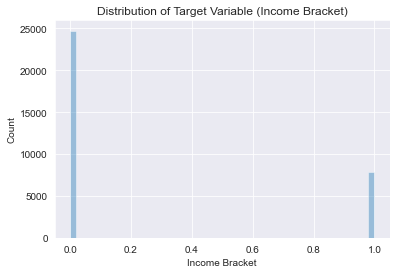

In [10]:
ax = sns.distplot(y, kde = False)
ax.set_title("Distribution of Target Variable (Income Bracket)")
ax.set(xlabel='Income Bracket', ylabel='Count')
plt.show()

**Answer**: The target variable is slightly imbalanced. There are about 25,000 instances of the "<=50k" label, and around 7500 instance of the ">50k" label. This imbalance could be a problem because a machine learning model could optimize accuracy by guessing "0" ("<=50k") more often.

### Train/Test/Validation Split

In general, machine learning models will tend to overfit the data they are trained on. As a machine learning model becomes more complex, it learns many of the idiosyncrasies in a dataset, but this tendency will mean it generalizes poorly. To assess the extent a model is prone to this problem, and make corrections, we always split our data before training our models.

The general procedure for this is the following:
1. Randomly divide our data set into two smaller sets: one for training and one for testing
2. Train the data on the training set, changing our model along the way to increase accuracy
3. Test the data's predictions using in test set.

Scikit-learn's [test_train_split function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) will help here. First, separate your data into two parts: a dataframe containing the features used to make our prediction, and an array of the true targets. We already made a dataframe with our features earlier when we created dummy variables, so now we need to make a target vector.

Now, set a random seed to ensure that we all get the same results when we sample. Then, use train_test_split to create a training set that contains 80% of the original dataset and a test set with 20% of the original data. Then check the shapes of each of the new sets.

**Validation set**

Because we may want to adjust our models, it is generally a good idea to save the test set until the very end and only use it once. Instead of going back and forth between the training and test set, we should instead use a validation set. Try using the train_test_split method to further split your training data so that 75% remains in training and 25% is reserved for validation. Note that this will mean the final split is 60% train, 20% validation, and 20% test. Check the dimensions of each.

In [11]:
# Set seed
np.random.seed(10)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .80, test_size=0.20,
                                                   stratify=y)

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, train_size = .75, test_size = .25, 
                                                           stratify = y_train)

## Decision Tree Classifier

A [decision tree classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) is a popular classification algorithm. A tree-based classifier learns to map the features to the target by creating a series of if-then-else decision rules.

<img src="https://github.com/Akesari12/Computational-Social-Science-Training-Program/blob/master/images/iris%20tree.png?raw=true" style="width: 500px; height: 275px;" />

Fill in the following code block to create a decision tree model. Then fit it on the training data, and report the accuracy in both the train and validation sets using the "score" method. Check the decision tree classifier documentaiton for help.

In [12]:
from sklearn import tree

dt_classifier = tree.DecisionTreeClassifier(criterion='gini',  # or 'entropy' for information gain
                       splitter='best',  # or 'random' for random best split
                       max_depth=None,  # how deep tree nodes can go
                       min_samples_split=2,  # samples needed to split node
                       min_samples_leaf=1,  # samples needed for a leaf
                       min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                       max_features=None,  # number of features to look for when splitting
                       max_leaf_nodes=None,  # max nodes
                       min_impurity_decrease=1e-07, #early stopping
                       random_state = 10) #random seed

In [13]:
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(min_impurity_decrease=1e-07, random_state=10)

In [14]:
print(dt_classifier.score(X_train, y_train))

1.0


In [15]:
print(dt_classifier.score(X_validate, y_validate))

0.8152641277641277


**Question**: How does your training accuracy compare to your validation accuracy? Why?

**Answer**: Validation accuracy is lower. Machine learning models will tend to overfit their training data, but then generalize less well to new unseen data.

Next, let's look at a unique aspect of tree-based methods: [**feature importances**](https://kdnuggets.com/2020/02/decision-tree-intuition.html). There are a few different ways to calculate a feature importance. One way to do it is to see how much information each new feature adds. If a feature does not add any or very little information to a prediction, it may be possible to safely drop it. Use the following code to put the feature importances and features into a dataframe, then plot the 10 largest feature importances. **Hint**: Consider using the [nlargest](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.nlargest.html) method.

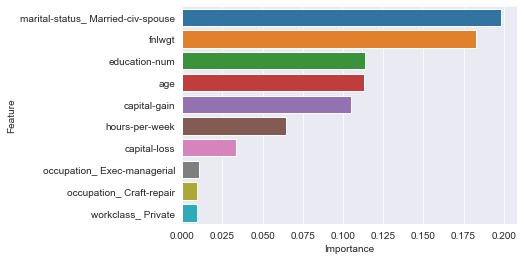

In [16]:
feat_importances = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(dt_classifier.feature_importances_))], axis = 1)
feat_importances.columns = ["Feature", "Importance"]
sns.barplot(x = "Importance", y = "Feature", data = feat_importances.nlargest(10, 'Importance'))
plt.show()

**Question**: Which features are the most important? How are these values different from a regression coefficient? How do you think these can be used to explain decisions based on machine learning?

**Answer**: These values are different from regression coefficients in that they are not an expression of statistical significance or causal effect, rather they are an expression of how much they influence an algorithm's prediction. They could be helpful for explaining black box decisions, but also could be unintuitive for people without statistical training.

Next, let's make predictions on the validation set. Then, visualize how your predictions with a confusion matrix. Refer back to the Intro to Machine Learning Lab or the [confusion matrix documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) if you need a reminder.

In [17]:
y_pred = dt_classifier.predict(X_validate)

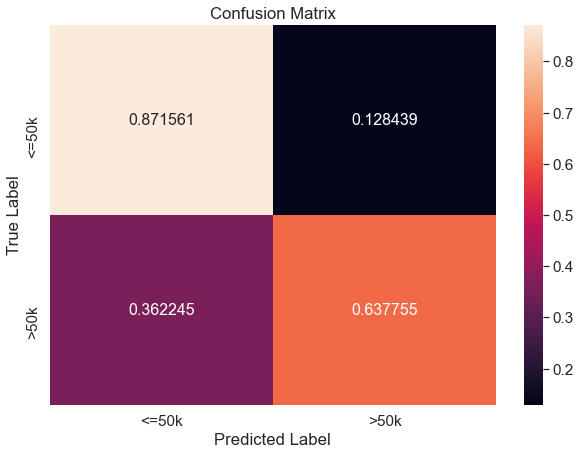

In [18]:
# normalize = true doesn't work for some people
cf_matrix = confusion_matrix(y_validate, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "<=50k", 1: ">50k"})
df_cm.index = ["<=50k", ">50k"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Logistic Regression

Next, let's look at a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Make a logistic regression model, fit it to the training data, and predict on the validation data.

In [19]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_train, y_train)

y_pred = logit_model.predict(X_validate)

C:\Users\Anike\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Next, create a dataframe with the features and the logit coefficients (Note: For the logit coefficients you need to use np.transpose or extract the coefficients from the 1d array). Then plot the 10 coefficients with the largest absolute value. Hint: Consider creating a new column with the absolute values for the coefficients, and then using the nlargest before plotting.

In [20]:
logit_data = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(logit_model.coef_))], axis = 1)
logit_data.columns = ['Feature', 'Coefficient']
logit_data['abs_coef'] = abs(logit_data['Coefficient'])

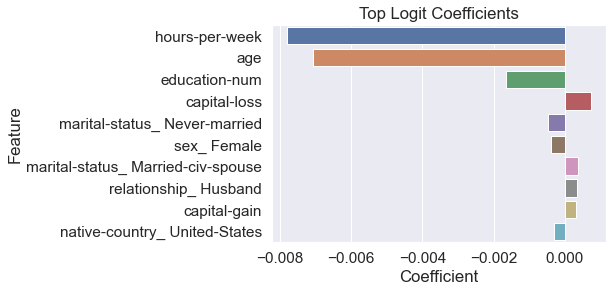

In [21]:
sns.barplot(x="Coefficient", y="Feature", data=logit_data.nlargest(10, 'abs_coef')).set_title("Top Logit Coefficients")
plt.show()

**Question**: How do the coefficients compare to the feature importances from the decision tree? Is there overlap? Are they interpretable from a decisionmaker's perspective?

**Answer**: There is some overlap between the largest logit coefficients and the largest features from the decision tree. However, log-odds coefficients may not be interpretable for similar reasons as they are not intuitive for people without statistical training.

Create a confusion matrix to visualize how well you did with your predictions. Are there differences between this confusion matrix and the one you created for the decision tree?

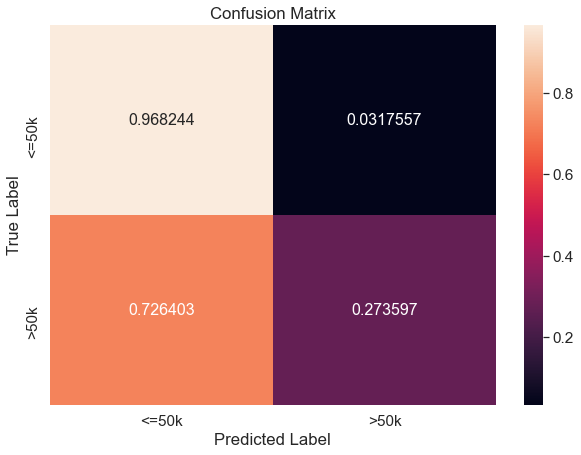

In [22]:
cf_matrix = confusion_matrix(y_validate, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "<=50k", 1: ">50k"})
df_cm.index = ["<=50k", ">50k"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Hyperparameter Tuning

As with sklearn's regression methods, we can also use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to search for optimal hyperparameters. Choose one of the classification methods we have used so far and do a grid search to find the best hyperparameter values. **Note**: You might notice that the grid search takes a **very** long time to complete depending on the model and hyperparameters chosen.

In [ ]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
              'C': np.arange(0.1, 1, 0.1),
              'fit_intercept': [True, False],
              'solver': ['liblinear', 'saga']}

logit_grid = GridSearchCV(logit_model, param_grid, cv=3)
logit_grid.fit(X_train, y_train)

best_index = np.argmax(logit_grid.cv_results_["mean_test_score"])
best_logit_pred = logit_grid.best_estimator_.predict(X_validate)

print(logit_grid.cv_results_["params"][best_index])
print('Validation Accuracy', accuracy_score(best_logit_pred, y_validate))


## Metrics

In machine learning, accuracy isn't the only metric that we might care about. Accuracy is an expression of ratio of correct observations relative to incorrect observations. This calculation alone does not tell us much about whether we did a good job predicting all of the various categories that we might be concerned about. Consider our census dataset. We saw earlier that the target data is not equally distributed - there were far more people with "<=50k" income. As we saw in our confusion matrices, our algorithms tended to predict observations belonging to the "<=50k" category remarkably well, but tended to do much worse with the ">50k" category. Why do you think this might be the case?

**Answer**: The class imbalance means that an algorithm can tend to do better just by picking the majority class. Accuracy might look good this way, but with a severe enough class imbalance, this score could be misleading.

Let's define a few metrics that will help us move beyond accuracy as our only measure:

$$
True \space Positives = \sum({Predicted \space Positives = Observed \space Positives})
$$

$$
False \space Positives = \sum({Predicted \space Positives \space != Observed \space Positives})
$$

$$
True \space Negatives = \sum({Predicted \space Negatives = Observed \space Negatives})
$$

$$
False \space Negatives = \sum({Predicted \space Negatives \space != Observed \space Negatives})
$$

Imagine we were primarily interested in detecting whether someone is ">50k". We'll call this the "positive" class. A "predicted" observation is the value the model predicted, while the "observed" observation is the value in the ground-truth labels. So a "true positive" in this case would be instances when the model predicted someone to be in the ">50k" category AND they were in the ">50k" category in reality. Similarly, a false positive would be instances where the model predicted someone was in the ">50k" category when they were actually in the "<=50k" category in reality. Use your best model from hyperparameter to predict on the validation set and see how you did on each of these metrics. **Hint**: The confusion matrix is actually a great way to visualize all of these. What does each quadrant of the matrix correspond to in terms of these metrics?

In [ ]:
cf_matrix = confusion_matrix(y_validate, best_logit_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "<=50k", 1: ">50k"})
df_cm.index = ["<=50k", ">50k"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**Answer**: The top left quadrant in this case would be true negatives, top right false positives, bottom left false negatives, bottom right true positives. In this case, we do a really good job with true negatives (.93), but not as well with true positives (.60). Because of the class imbalance there are still a large number of false negatives.

These metrics matter in the social sciences because we usually are not given balanced datasets, and we are oftentimes concerned with predicting rare events. Predicting rare events like fraud, credit defaults, and mortality is difficult. Optimizing on accuracy alone can be misleading if the algorithm just guesses the majority class every time without ever predicting the outcome of interest. Next week we will delve even deeper into these concepts.

**Accuracy**

Accuracy can be expressed as:

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

The numerator is the number of correction predictions regardless of direction, divided by the total number observations (correct predictions + incorrect predictions).

**Precision**
  
Precision is a measure of how well calibrated predictions are. The formula for precision is:

$$
Precision = \frac{TP}{TP + FP}
$$

This formula tell us of the predictions in the positive class (">50k" in this case) we made, how many were correct.

**Recall**

Recall is defined as:

$$
Recall = \frac{TP}{TP + FN}
$$

Of all of the positive class members in the ground truth labels, how many did we successfully predict as positive?

**F1 Score**

  The precision-recall tradeoff can be managed in a few different ways. One popular metric is the F1 score. It is defined as:

$$
F1 = 2 * \frac{precision * recall}{precision + recall}
$$

F1 is advantageous because the numerator can be penalized by either low precision OR recall. The disadvantage of this approach is that without adjustments, the F1 score prioritizes precision and recall equally. Depending on the application, we might care about one more than the other.

**AUC-ROC**

[Area Under the Curve - Receiver Operating Characteristic (AUC-ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is a popular method for seeing how well an algorithm does at separating between two classes. It is calculated by plotting the True Positive Rate against the False Positive Rate. Let's define these quantities:

$$
True \space Positive \space Rate(TPR) = Sensitivity = \frac{TP}{TP + FN}
$$

Hm, this formula looks familiar. In fact, it is exactly the same as Recall! Meanwhile, the False Positive Rate is:

$$
False \space Positive \space Rate (FPR) = 1 - Specificity = \frac{FP}{TN + FP}
$$

By comparing TPR to FPR, we can see how well a model does at detecting the positive class. A TPR of 1 and a FPR of 0 would imply that the model does a perfect job at classifying positives as positives and negatives as negatives. It basically contextualizes Recall.

In [ ]:
TP = 0
FP = 0
TN = 0
FN = 0

for i in range(len(y_pred)): 
    if y_validate[i]==y_pred[i]==1:
       TP += 1
    if y_pred[i]==1 and y_validate[i]!=y_pred[i]:
       FP += 1
    if y_validate[i]==y_pred[i]==0:
       TN += 1
    if y_pred[i]==0 and y_pred[i]!=y_validate[i]:
       FN += 1



In [ ]:
(TP+TN)/(TP + TN + FP + FN)

In [ ]:
accuracy = (TP + TN)/(TP + TN + FP + FN)
precision = TP/(TP + FP)
recall = TP/(TP + FN)
f1 = 2 * (precision * recall)/(precision + recall)
print("Accuracy is", round(accuracy,3))
print("Precision is", round(precision,3))
print("Recall is", round(recall,3))
print("F1 Score is", round(f1,3))

In [ ]:
### roc curve and auc

# split into train/test sets
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_validate))]


# predict probabilities for logistic regression
lr_probs = logit_model.predict_proba(X_validate)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_validate, ns_probs)
lr_auc = roc_auc_score(y_validate, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_validate, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_validate, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Over and Under Sampling

We have seen that imbalanced data can cause all sorts of problems and give us misleading results, especially if we only focus on accuracy. How can we correct for these problems? One simple method is to **resample** the data. For example, you might **oversample** the minority class or **undersample** the majority class. Let's use the [**imblearn**](https://imbalanced-learn.readthedocs.io/en/stable/api.html) to try this out. First, you might need to run the cell below to install the library. Anytime you use "!" in a Jupyter notebook, this will actually run a bash command.

Now let's import the RandomOverSampler and RandomUnderSampler methods. Then take a look at the first 15 values in y_train before we resample.

Why would we resample the training set, instead of the dataset or the validation/test sets?
We want our evaluations to be as close to reality as possible. If the actual social science or policy problem has imbalanced class labels, we don't want to make an algorithm look artificially good by validating and testing in a resampled dataset that does not resemble the ground truth.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

random_over_sampler = RandomOverSampler(sampling_strategy=0.5)
random_under_sampler = RandomUnderSampler(sampling_strategy=0.5)

X_train_new, y_train_new = random_under_sampler.fit_resample(X_train, y_train)

Retrain the logistic regression model on the newly resampled data. How does AUC-ROC change?

In [ ]:
# fit the model
logit_model = logit_reg.fit(X_train_new, y_train_new)

y_pred = logit_model.predict(X_validate)

# roc curve and auc

# split into train/test sets
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_validate))]


# predict probabilities for logistic regression
lr_probs = logit_model.predict_proba(X_validate)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_validate, ns_probs)
lr_auc = roc_auc_score(y_validate, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_validate, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_validate, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Overall, while sklearn puts together many of the methods we need to train, predict, and visualize the results of our machine learning, there are a lot of substantive choices involved. As you can see, even a slightly imbalanced dataset can cause problems. If you optimize only on accuracy, you might miss relevant aspects of the problem. Be mindful of the various metrics available, and decide which ones best answer the scientific question you have in mind.